In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse
import testing_2 as tst

## Importo Ti de las ZT base y con imputaciones (base,mean y ann)

In [269]:
# pbscom
# n2str
# n1au404
sim_base=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/Base_simulation.csv',index_col=0,parse_dates=True)
to_base=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/t_outside.csv',index_col=0,parse_dates=True)
sim_ann_imp=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/ann_imputation_simulation.csv',index_col=0,parse_dates=True)
sim_mean_imp=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/mean_imputation_simulation.csv',index_col=0,parse_dates=True)
sim_sarima_imp=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/SARIMA_imputation_simulation.csv',index_col=0,parse_dates=True)
sim_sarima_1_0_0_imp=pd.read_csv('../01_data/05_simulation_data/01_simulation_csvs/SARIMA_0_1_1_imputation_simulation.csv',index_col=0,parse_dates=True)
# sim_assemble=pd.concat((sim_base,sim_ann,sim_mean),)
sim_base['error_mean']=sim_mean_imp.PBSCOM-sim_base.PBSCOM
sim_base['error_ann']=np.abs(sim_ann_imp.PBSCOM-sim_base.PBSCOM)

In [5]:
dias=['2018-01-30 07:20:00','2018-03-29 06:40:00'
,'2018-06-15 06:10:00'
,'2018-06-27 06:10:00'
,'2018-07-28 06:20:00'
,'2018-08-12 06:30:00'
,'2018-10-05 06:40:00'
,'2018-11-14 06:50:00']

## TZ de Nivel 2

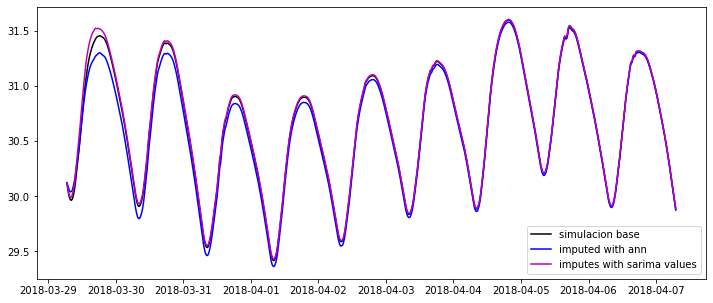

In [6]:
fig, ax=plt.subplots(figsize=(12,5))
dia=1
days_after='10D'
ax.plot(sim_base.N2STR.loc[dias[dia]:'2018-04-07 07:00:00'],'k-',label='simulacion base')

ax.plot(sim_ann_imp.N2STR.loc[dias[dia]:'2018-04-07 07:00:00'],'b-',label='imputed with ann')
# ax.plot(sim_mean_imp.N2STR.loc[dias[dia]:'2018-04-07 07:00:00'],'m-',label='imputes with mean values')
ax.plot(sim_sarima_imp.N2STR.loc[dias[dia]:'2018-04-07 07:00:00'],'m-',label='imputes with sarima values')
# ax2=ax.twinx()
# ax2.plot(sim_base.error_ann.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'r-',label='error')
# ax2.plot(sim_base.error_mean.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'y-',label='error')
# ax2.set_ylim(0,.51)
ax.legend()

## Nivel 1

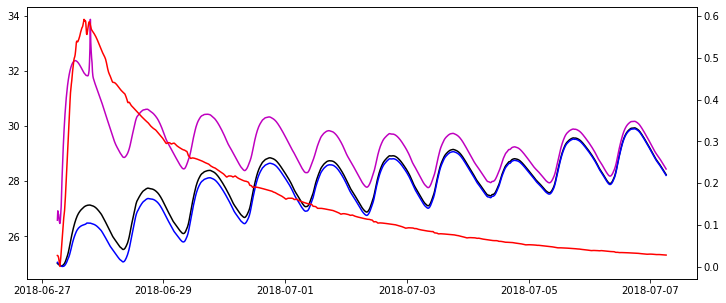

In [42]:
fig, ax=plt.subplots(figsize=(12,5))
days_after='10D'
ax.plot(sim_base.N1AU404.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'k-',label='simulacion base')
ax.plot(sim_ann_imp.N1AU404.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'b-',label='imputed with ann')
ax.plot(sim_mean_imp.N1AU404.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'m-',label='imputes with mean values')
ax2=ax.twinx()
ax2.plot(sim_base.error_mean.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'r-',label='error')

# ax.set_ylim(0,.1)

## ZT de PB

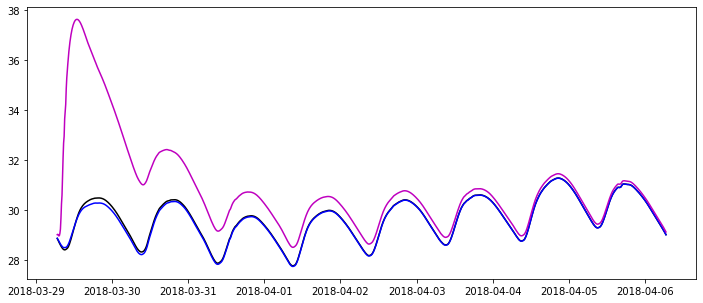

In [8]:
fig, ax=plt.subplots(figsize=(12,5))
days_after='8D'
ax.plot(sim_base.PBSCOM.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'k-',label='simulacion base')
ax.plot(sim_ann_imp.PBSCOM.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'b-',label='imputed with ann')
ax.plot(sim_mean_imp.PBSCOM.loc[dias[dia]:parse(dias[dia])+pd.Timedelta(days_after)],'m-',label='imputes with mean values')

## Vanishing time

In [9]:
def vanishing_time(df_base,df2,dias,dia,tolerance,zt):
    df=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
    df=df.loc[parse(dias[dia])+pd.Timedelta('1H'):parse(dias[dia])+pd.Timedelta('100D')].resample('11H').mean()
    df.loc[df[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
    df=df[df.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
    vanish_time=pd.Timedelta(df.index[0]-parse(dias[dia]))
    print('vanishing_time:',vanish_time)
    return(vanish_time,df)

In [10]:
def graph(sim_base,sim_ann_imp,sim_mean_imp,zt,dia1,vanish_time):
    
    sim_base['error_mean']=np.abs(sim_mean_imp[zt]-sim_base[zt])
    sim_base['error_ann']=np.abs(sim_ann_imp[zt]-sim_base[zt])
    fig, ax=plt.subplots(figsize=(12,5))
    ax.plot(sim_base[zt].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
    ax.plot(sim_ann_imp[zt].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'b-',label='imputed with ann')
#     ax.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
    ax2=ax.twinx()
#     ax2.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
    ax.plot(sim_mean_imp[zt].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'m-',label='imputes with sarima values')
    ax2.plot(sim_base.error_ann.loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'r-',label='error')
    ax.legend()
    ax.grid()

In [11]:
path_to_ann='../01_data/01_PreEPW/Temixco_2018_imputado_ANN.csv'
to_ann=pd.read_csv(path_to_ann,index_col=0,parse_dates=True,skiprows=(1,1))
# path_to_base='../01_data/Temixco_2018_N006c.csv'
# to_base=pd.read_csv(path_to_base,index_col=0,parse_dates=True,skiprows=(1,1))

In [12]:
zt='N2STR'
dia=2
#tiempo de ... error m'aximo, alcanzar el criterio, tiempo total 
#Criterio de parada de vanishing time de 
# Presentaci'on de ARIMA 10 min 
# Compartir repo de escritura Tesis x
vanish,df=vanishing_time(sim_base,sim_ann_imp,dias,dia,.1,zt)
df.index[0]

vanishing_time: 7 days 23:50:00


Timestamp('2018-06-23 06:00:00')

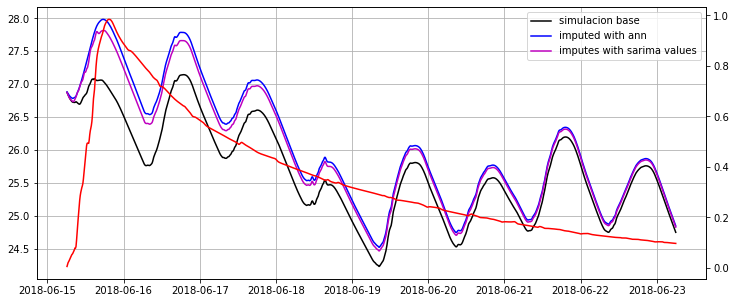

In [13]:
graph(sim_base,sim_ann_imp,sim_sarima_imp,zt,dias[dia],vanish)

# All metrics function

## 2nd try Vanishing time

In [14]:
#vanishing time con un mean rolling. 
# tiempo maximo de error 
# error m'aximo 

In [159]:
def vanishing_time(df_base,df2,dias,dia,tolerance,zt):
    df=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
    df=df.loc[parse(dias[dia])+pd.Timedelta('4H'):parse(dias[dia])+pd.Timedelta('100D')].resample('11H').mean()
    df.loc[df[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
    df=df[df.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
    vanish_time=pd.Timedelta(df.index[0]-parse(dias[dia]))
    print('vanishing_time:',vanish_time)
    return(vanish_time,df)

In [243]:
#La idea es hacer que si el df_diff es mayor a cero, ir al otro df_intolerated
#solo el dia  6 falla 

def simulation_metrics(df_base,df2,dias,dia,tolerance,zt):
    df_inic=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
    df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('4H'):parse(dias[dia])+pd.Timedelta('100D')]
    df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('4H'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean()
    df_rolled.loc[df_rolled[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
    df_end=df_rolled[df_rolled.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
    df_diff=df_inic.loc[parse(dias[dia])+pd.Timedelta('50Min'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*5,center=True).mean().diff()
    i=0
    while(True):
        i=i+1
        df_end_index=str(df_end.index[i])
        if df_diff[zt].loc[df_end_index]<0:
            break
    vanish_time=pd.Timedelta(df_end.index[i]-parse(dias[dia]))
    print('vanish_time:',vanish_time)
    max_index_error=parse(str(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].idxmax()))
    max_error=df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].max()
    max_time=pd.Timedelta(max_index_error-parse(dias[dia]))
    down_time=df_end.index[i]-max_index_error
    print('tiempo de maximo error:',max_index_error)
    print('tiempo para maximo error:',max_time)
    print('tiempo de bajada:',down_time)
    print('valor maximo de error:',max_error)

    return(vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff)

In [244]:
#TIempo de bajada, (del maximo a la tolerancia)                                                      sim_base,sim_imputed,dias,dia,tolerance,thermal_zone
dia=0
tolerance=.1
zt=thermal_zone
vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(sim_base,sim_ann_imp,dias,dia,tolerance,zt)

vanish_time: 4 days 14:30:00
tiempo de maximo error: 2018-01-30 18:20:00
tiempo para maximo error: 0 days 11:00:00
tiempo de bajada: 4 days 03:30:00
valor maximo de error: 0.4268885207359432


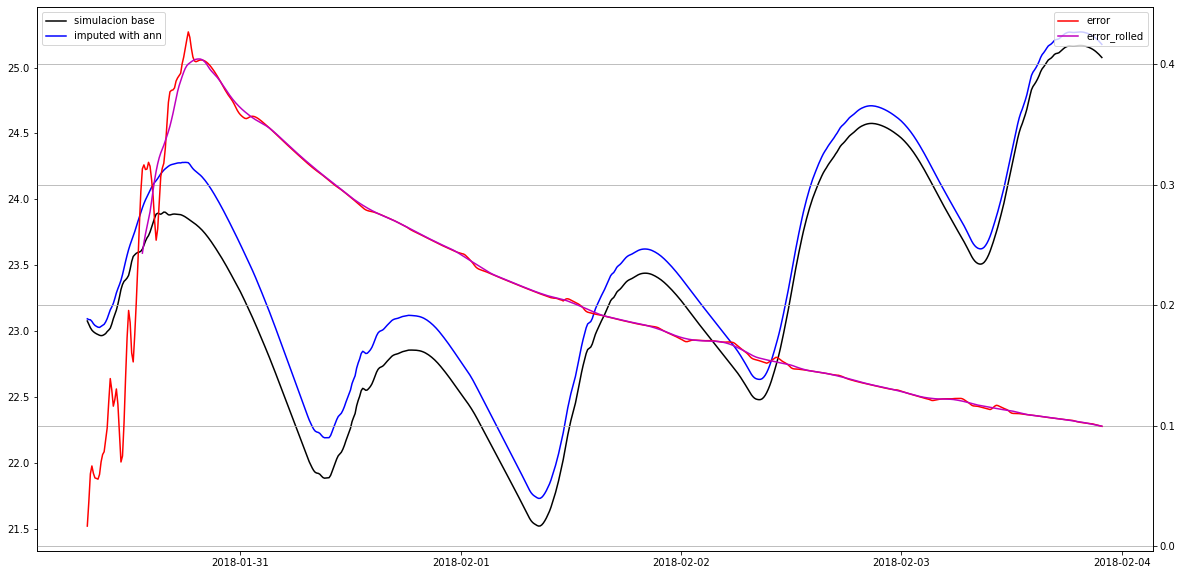

In [238]:
fig, ax=plt.subplots(figsize=(20,10))
ax.plot(sim_base[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
ax.plot(sim_ann_imp[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'b-',label='imputed with ann')
#     ax.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
ax2=ax.twinx()
#     ax2.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
#     ax.plot(sim_mean_imp[zt].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'m-',label='imputes with mean values')
ax2.plot(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',label='error')
ax2.plot(df_rolled[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='error_rolled')
ax.legend()
ax2.legend()
ax2.grid()
plt.show()

In [239]:
def actualizar_bitacora(infodf,cols_gen,path,nombre_archivo): #adds a new row on a predetermined dataframe 
    df=pd.read_csv(path+nombre_archivo)
    infodf=pd.DataFrame(data=infodf,columns=cols_gen)
    newdf=pd.concat([df,infodf])
    newdf=newdf.set_index('Maximum error')
    newdf.to_csv(path+nombre_archivo)
    return(pd.read_csv((path+nombre_archivo)))


In [240]:
#Solo correr cuando es el primer valor de la tabla
first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
cols=['Date_imputed','vanishing_time','Maximum error','Time of maximum error','Time for maximum error','Time from maximum to tolerated error']
simulation_metrics=pd.DataFrame(first,columns=cols)
simulation_metrics=simulation_metrics.set_index('Maximum error')
simulation_metrics.to_csv('../01_data/06_simulations_metrics/ANN_imputation_metrics.csv')
simulation_metrics

,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
Maximum error,,,,,
0.426889,2018-01-30 07:20:00,4 days 14:30:00,2018-01-30 18:20:00,0 days 11:00:00,4 days 03:30:00


In [241]:
first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
path_metrics='../01_data/06_simulations_metrics/'
file_metrics='ANN_imputation_metrics.csv'
pd.read_csv(path_metrics+file_metrics)
actualizar_bitacora(first,cols,path_metrics,file_metrics)

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.426889,2018-01-30 07:20:00,4 days 14:30:00,2018-01-30 18:20:00,0 days 11:00:00,4 days 03:30:00
1,0.426889,2018-01-30 07:20:00,4 days 14:30:00,2018-01-30 18:20:00,0 days 11:00:00,4 days 03:30:00


In [203]:
path_metrics='../01_data/06_simulations_metrics/'
file_metrics='ANN_imputation_metrics.csv'


def automated_simulation_metrics(path_metrics,file_metrics,sim_base,sim_imputed,dias,dia,tolerance=.1,thermal_zone=zt):
    vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
#     fig, ax=plt.subplots(figsize=(20,10))
#     ax.plot(sim_base[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'k-',label='simulacion base')
#     ax.plot(sim_ann_imp[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'b-',label='imputed with ann')
    #     ax.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
#     ax2=ax.twinx()
    #     ax2.plot(to_ann['To'].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'y-',label='imputed To')
    #     ax.plot(sim_mean_imp[zt].loc[dia1:parse(dia1)+pd.Timedelta(vanish_time)],'m-',label='imputes with mean values')
#     ax2.plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'r-',label='error')
#     ax2.plot(df_rolled[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'m-',label='error_rolled')
#     ax.legend()
#     ax2.legend()
#     ax2.grid()
#     plt.show()
    if dia==0:
        first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
        cols=['Date_imputed','vanishing_time','Maximum error','Time of maximum error','Time for maximum error','Time from maximum to tolerated error']
        simulation_metrics=pd.DataFrame(first,columns=cols)
        simulation_metrics=simulation_metrics.set_index('Maximum error')
        simulation_metrics.to_csv(path_metric+file_metrics)
    else:
        first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
        actualizar_bitacora(first,cols,path_metrics,file_metrics)

In [213]:

for dia in range(len(dias)):
    automated_simulation_metrics(path_metrics,file_metrics,sim_base,sim_sarima_imp,dias,dia,tolerance=.2,thermal_zone=tz)

UnboundLocalError: local variable 'simulation_metrics' referenced before assignment

vanish_time: 2 days 11:00:00


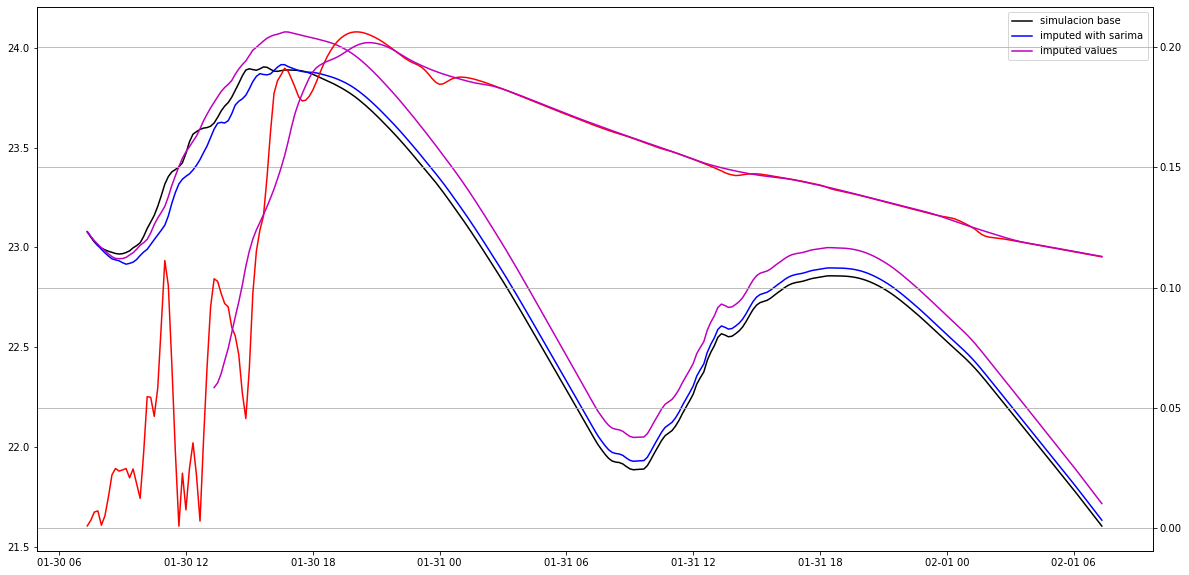

vanish_time: 0 days 06:50:00


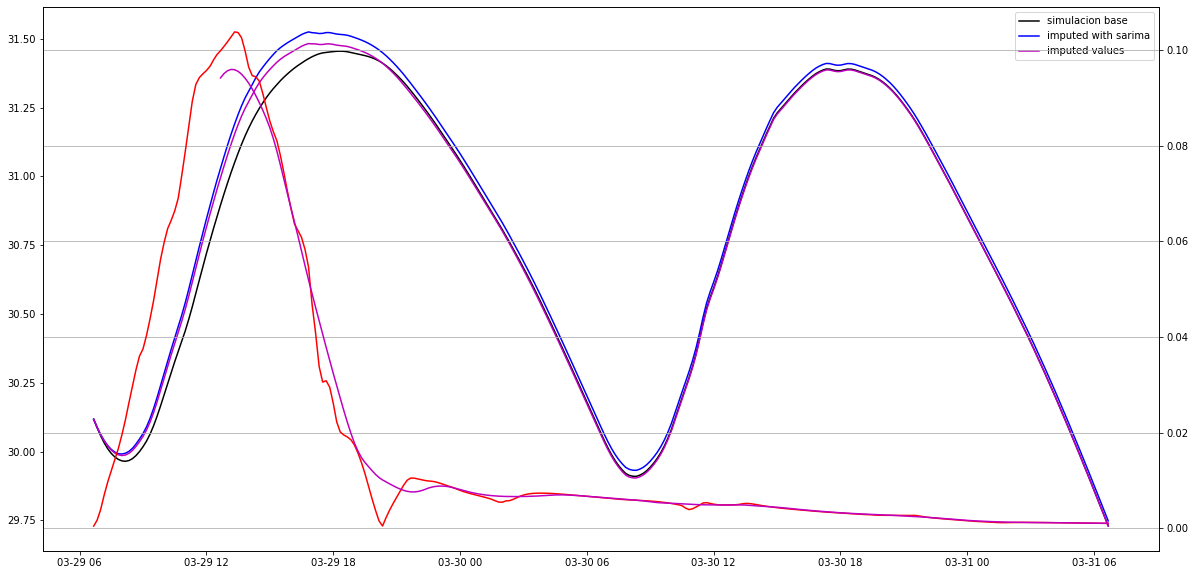

vanish_time: 7 days 09:20:00


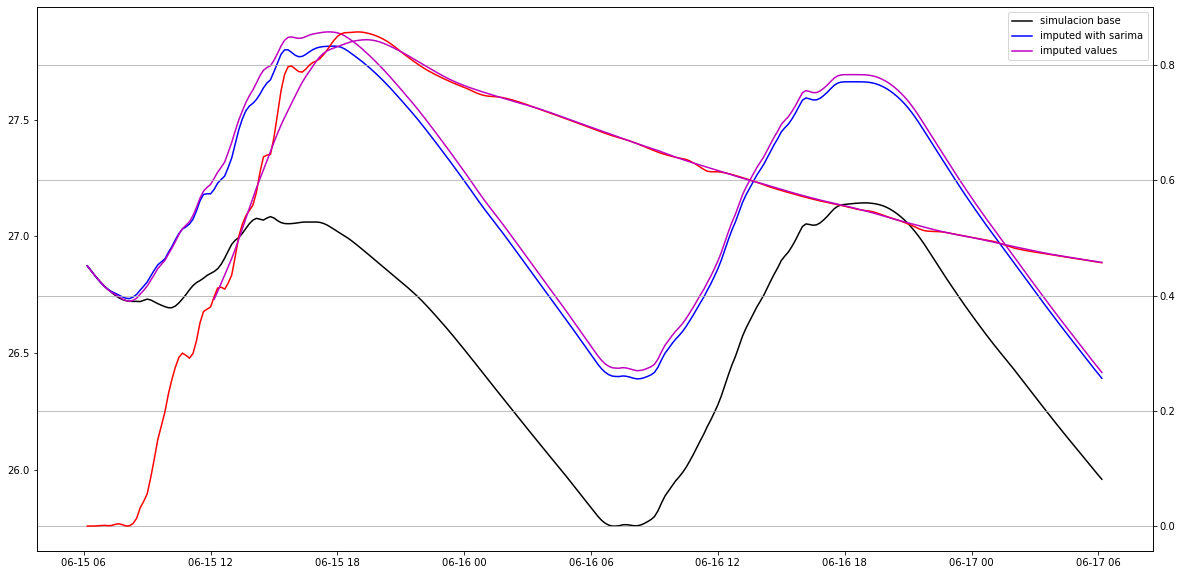

vanish_time: 5 days 01:40:00


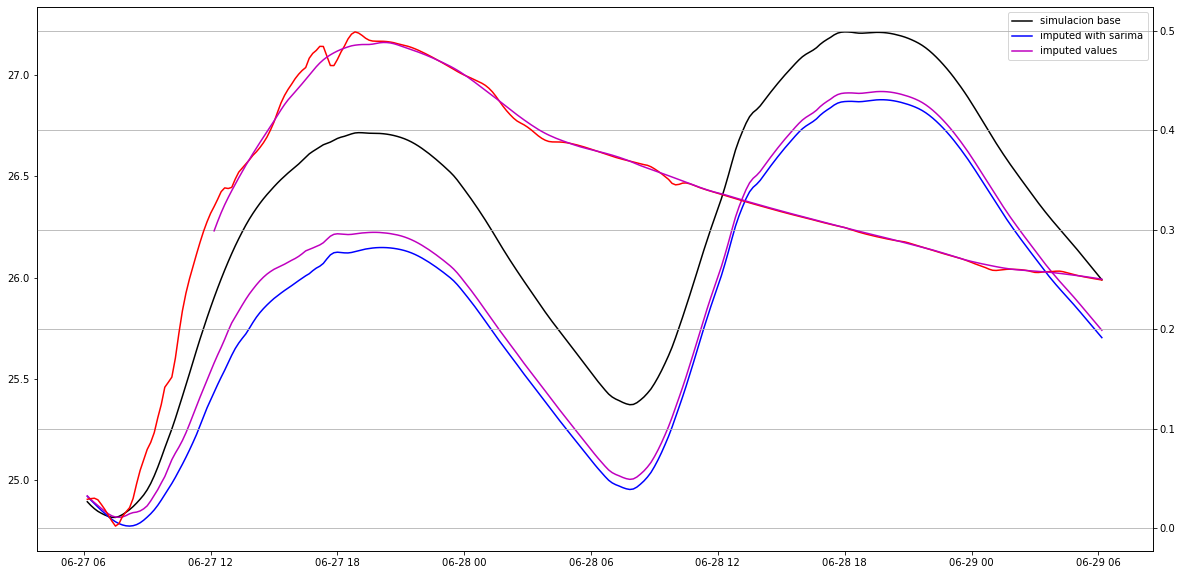

vanish_time: 0 days 11:20:00


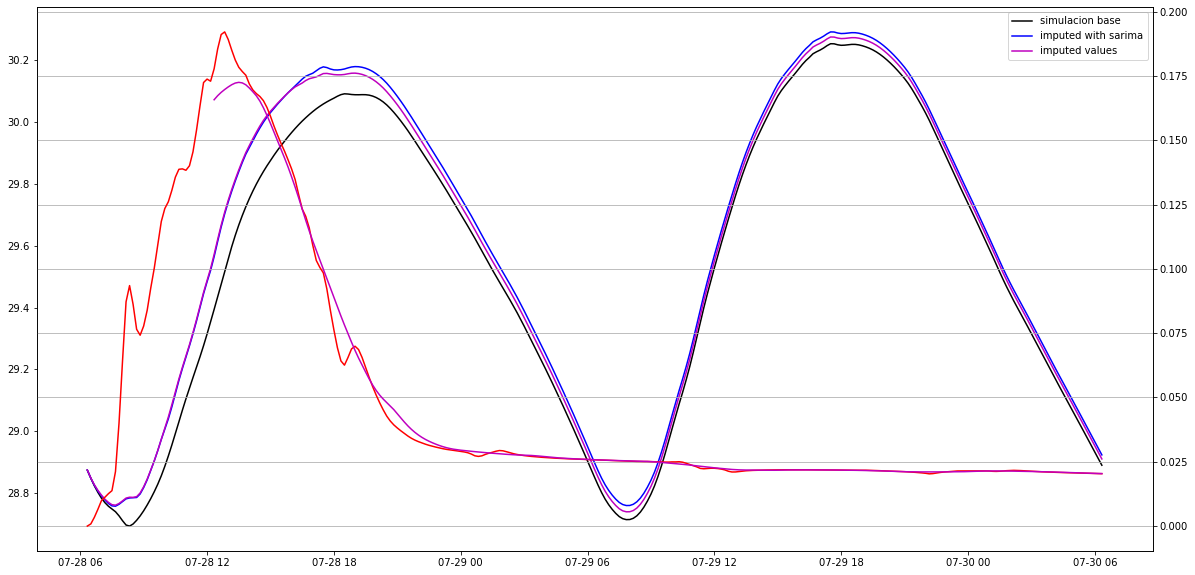

vanish_time: 8 days 13:20:00


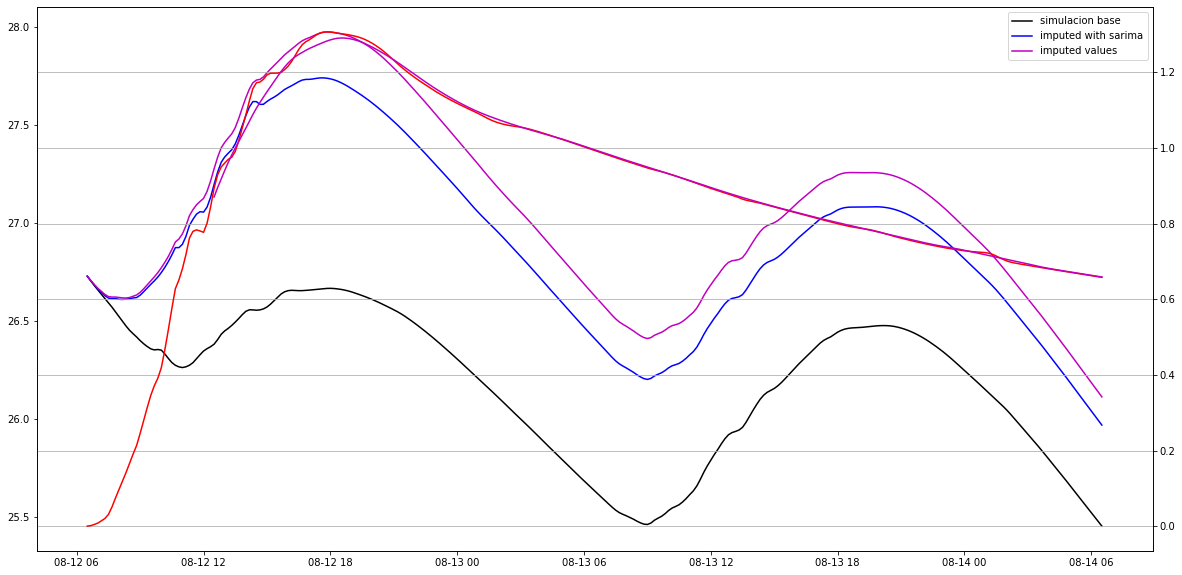

vanish_time: 0 days 06:10:00


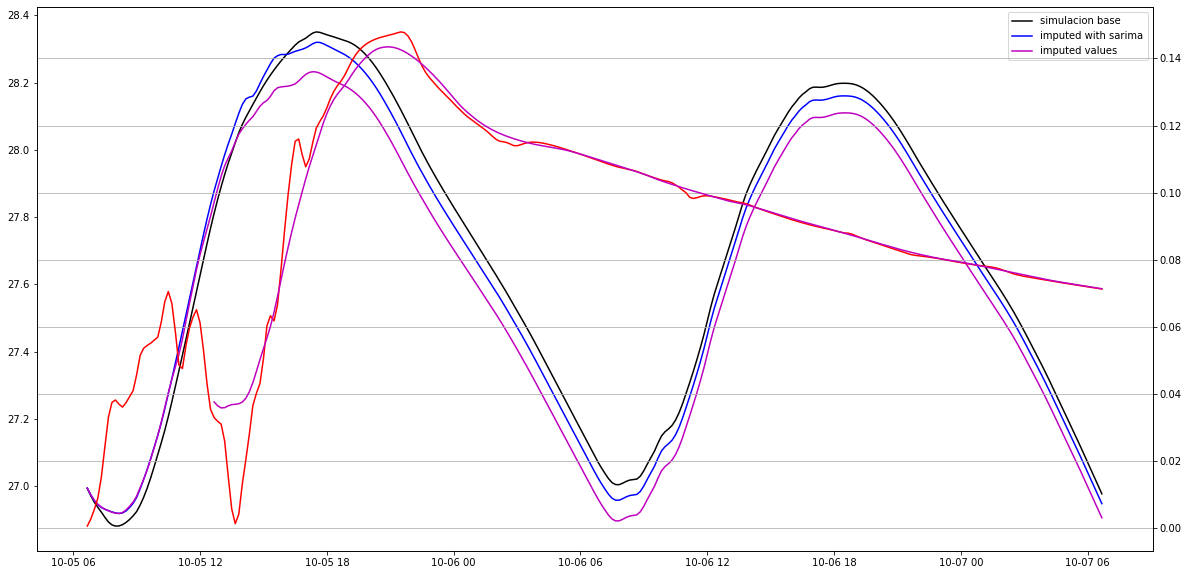

vanish_time: 8 days 16:40:00


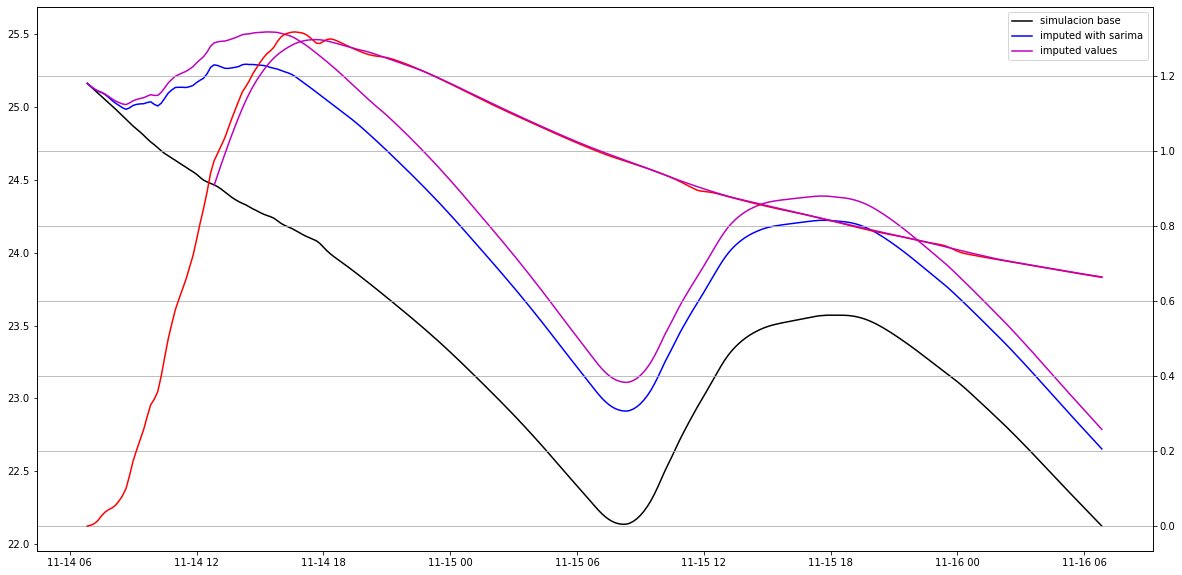

In [287]:
tolerance=.1
thermal_zone='N2STR'
path_metrics='../01_data/06_simulations_metrics/'
file_metrics='sarima_0_1_1_imputation_metrics'+thermal_zone+'.csv'
tz='N2STR'
sim_imputed=sim_sarima_1_0_0_imp
save=False
for dia in range(len(dias)):
    def simulation_metrics(df_base,df2,dias,dia,tolerance,zt):
        df_inic=pd.DataFrame(np.abs(df_base[zt]-df2[zt]))
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('4H'):parse(dias[dia])+pd.Timedelta('100D')]
        df_rolled=df_inic.loc[parse(dias[dia])+pd.Timedelta('4H'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*4,center=True).mean()
        df_rolled.loc[df_rolled[zt]<tolerance,'vanish_day']=True #Gets the time in which the mean difference of the hour is less than the tolerance
        df_end=df_rolled[df_rolled.vanish_day.isnull()==False] #Obtains the first time the conditional from above is true
        df_diff=df_inic.loc[parse(dias[dia])+pd.Timedelta('50Min'):parse(dias[dia])+pd.Timedelta('100D')].rolling(6*5,center=True).mean().diff()
        i=0
        while(True):
            i=i+1
            df_end_index=str(df_end.index[i])
            if df_diff[zt].loc[df_end_index]<0:
                break
        vanish_time=pd.Timedelta(df_end.index[i]-parse(dias[dia]))
        print('vanish_time:',vanish_time)
        max_index_error=parse(str(df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].idxmax()))
        max_error=df_inic[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)].max()
        max_time=pd.Timedelta(max_index_error-parse(dias[dia]))
        down_time=df_end.index[i]-max_index_error
    #     print('tiempo de maximo error:',max_index_error)
    #     print('tiempo para maximo error:',max_time)
    #     print('tiempo de bajada:',down_time)
    #     print('valor maximo de error:',max_error)

        return(vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff)
    vanish_time,max_index_error,max_time,down_time,max_error,df_rolled,df_inic,df_diff=simulation_metrics(sim_base,sim_imputed,dias,dia,tolerance,thermal_zone)
    fig, ax=plt.subplots(figsize=(20,10))
    ax.plot(sim_base[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta('2D')],'k-',label='simulacion base')
    ax.plot(sim_sarima_imp[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta('2D')],'b-',label='imputed with sarima')
#     ax.plot(to_ann['To'].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'y-',label='imputed To')
    ax2=ax.twinx()
#     ax2.plot(to_ann['To'].loc[dias[dia]:parse(dias[dia])+pd.Timedelta(vanish_time)],'y-',label='imputed To')
    ax.plot(sim_imputed[zt].loc[dias[dia]:parse(dias[dia])+pd.Timedelta('2D')],'m-',label='imputed values')
    ax2.plot(df_inic[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta('2D')],'r-',label='error')
    ax2.plot(df_rolled[thermal_zone].loc[dias[dia]:parse(dias[dia])+pd.Timedelta('2D')],'m-',label='error_rolled')
    ax.legend()
    #ax2.legend()
    ax2.grid()
    plt.show()
    if save==True:
        if dia==0:
            first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
            cols=['Date_imputed','vanishing_time','Maximum error','Time of maximum error','Time for maximum error','Time from maximum to tolerated error']
            simulation_metrics=pd.DataFrame(first,columns=cols)
            simulation_metrics=simulation_metrics.set_index('Maximum error')
            simulation_metrics.to_csv(path_metrics+file_metrics)
        else:
            first=np.array([dias[dia],vanish_time,max_error,max_index_error,max_time,down_time]).reshape(1,6)
            actualizar_bitacora(first,cols,path_metrics,file_metrics)


In [274]:
sarima_0_1_1metrics=pd.read_csv(path_metrics+'sarima_0_1_1_imputation_metricsN2STR.csv')

In [260]:
sarima_metrics=pd.read_csv(path_metrics+'SARIMA_imputation_metricsN2STR.csv')
sarima_metrics

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.205282,2018-01-30 07:20:00,0 days 06:20:00,2018-01-30 11:00:00,0 days 03:40:00,0 days 02:40:00
1,0.140361,2018-03-29 06:40:00,0 days 10:00:00,2018-03-29 13:30:00,0 days 06:50:00,0 days 03:10:00
2,0.802626,2018-06-15 06:10:00,7 days 03:30:00,2018-06-15 19:20:00,0 days 13:10:00,6 days 14:20:00
3,0.592010,2018-06-27 06:10:00,5 days 13:40:00,2018-06-27 16:40:00,0 days 10:30:00,5 days 03:10:00
4,0.186447,2018-07-28 06:20:00,0 days 12:20:00,2018-07-28 12:50:00,0 days 06:30:00,0 days 05:50:00
5,1.075635,2018-08-12 06:30:00,7 days 15:30:00,2018-08-12 17:30:00,0 days 11:00:00,7 days 04:30:00
6,0.074879,2018-10-05 06:40:00,0 days 06:10:00,2018-10-05 12:00:00,0 days 05:20:00,0 days 00:50:00
7,1.057654,2018-11-14 06:50:00,7 days 22:30:00,2018-11-14 16:30:00,0 days 09:40:00,7 days 12:50:00


In [266]:
ann_metrics=pd.read_csv(path_metrics+'ANN_imputation_metricsN2STR.csv')
ann_metrics

,Maximum error,Date_imputed,vanishing_time,Time of maximum error,Time for maximum error,Time from maximum to tolerated error
0,0.426889,2018-01-30 07:20:00,4 days 14:30:00,2018-01-30 18:20:00,0 days 11:00:00,4 days 03:30:00
1,0.161006,2018-03-29 06:40:00,1 days 08:00:00,2018-03-29 19:20:00,0 days 12:40:00,0 days 19:20:00
2,0.984014,2018-06-15 06:10:00,7 days 21:50:00,2018-06-15 19:20:00,0 days 13:10:00,7 days 08:40:00
3,0.578464,2018-06-27 06:10:00,5 days 11:10:00,2018-06-27 17:10:00,0 days 11:00:00,5 days 00:10:00
4,0.304862,2018-07-28 06:20:00,3 days 07:10:00,2018-07-28 20:10:00,0 days 13:50:00,2 days 17:20:00
5,1.114065,2018-08-12 06:30:00,8 days 01:40:00,2018-08-12 19:10:00,0 days 12:40:00,7 days 13:00:00
6,0.165490,2018-10-05 06:40:00,1 days 10:40:00,2018-10-05 19:40:00,0 days 13:00:00,0 days 21:40:00
7,1.251005,2018-11-14 06:50:00,8 days 14:20:00,2018-11-14 17:50:00,0 days 11:00:00,8 days 03:20:00


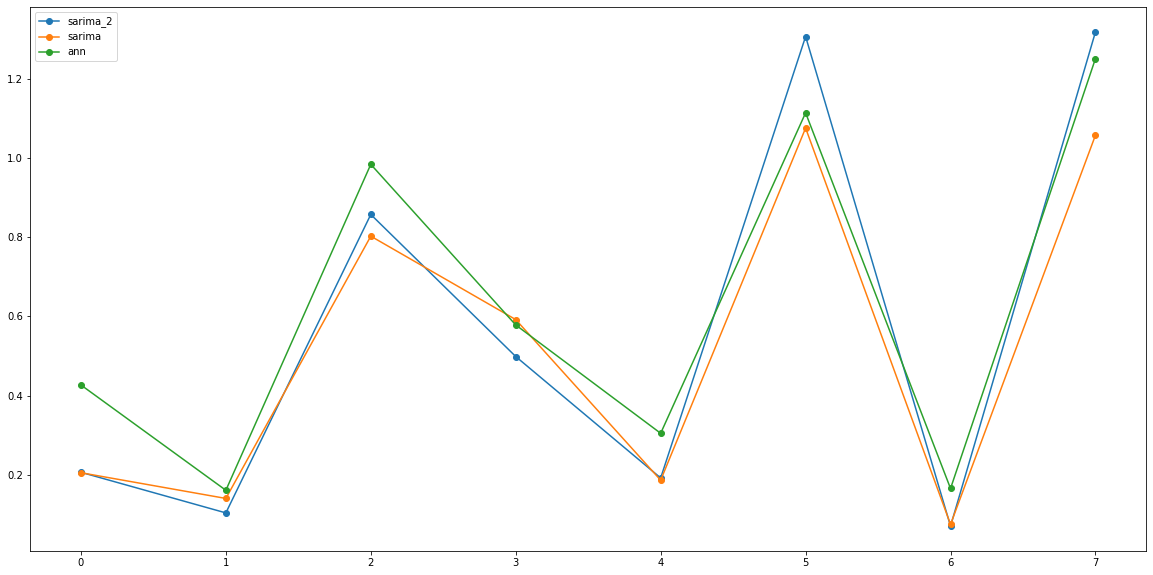

In [283]:
fig, ax=plt.subplots(figsize=(20,10))
ax.plot(sarima_0_1_1metrics['Maximum error'],'o-',label='sarima_2')
ax.plot(sarima_metrics['Maximum error'],'o-',label='sarima')
ax.plot(ann_metrics['Maximum error'],'o-',label='ann')
ax.legend()